In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/DDoS.csv')

In [3]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [4]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data[' Label'] = label_encoder.fit_transform(data[' Label'])

In [7]:
# Split features and target variable
X = data.drop(' Label', axis=1)
y = data[' Label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [11]:
selected_features_indices = selector.get_support(indices=True)

In [12]:
selected_feature_names = X.columns[selected_features_indices]

In [13]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index([' Destination Port', 'Total Length of Fwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Mean',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Bwd IAT Total',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', ' URG Flag Count',
       ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Avg Bwd Segment Size', ' Subflow Fwd Bytes', ' min_seg_size_forward'],
      dtype='object')


In [15]:
# Load the saved models
rf_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/random_forest_model_ddos.pkl')
svm_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/DDoS_svm_model.pkl')
nb_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/DDoS_nb_model.pkl')

In [16]:
# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('svm', svm_model),
    ('naive_bayes', nb_model)
], voting='hard')

In [17]:
# Fit the ensemble model on the training data
voting_clf.fit(X_train_selected, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('naive_bayes', GaussianNB())])

In [18]:
# Predictions
y_pred_ensemble = voting_clf.predict(X_test_selected)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Evaluation metrics
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)
ensemble_conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

In [20]:
# Print evaluation metrics
print("Ensemble Model Evaluation:")
print("Accuracy:", ensemble_accuracy)
print("Precision:", ensemble_precision)
print("F1-score:", ensemble_f1)
print("Confusion Matrix:")
print(ensemble_conf_matrix)

Ensemble Model Evaluation:
Accuracy: 0.9857563741886892
Precision: 0.9756134562142071
F1-score: 0.9876562170048568
Confusion Matrix:
[[18776   643]
 [    0 25724]]


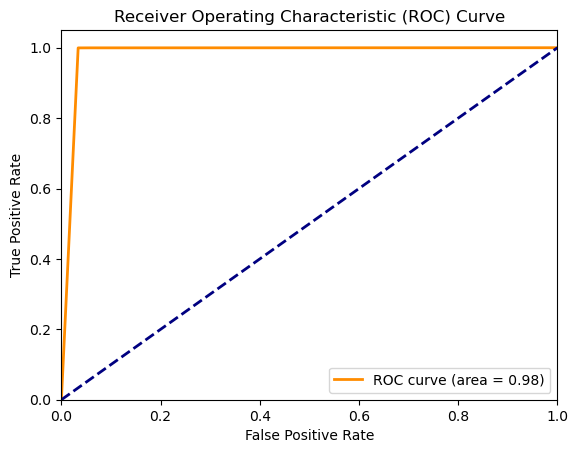

In [21]:
# Compute probabilities for ROC curve
y_prob = nb_model.predict_proba(X_test_selected)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[18776   643]
 [    0 25724]]


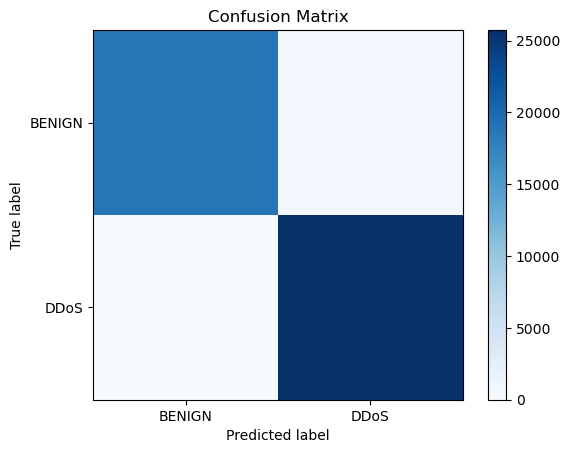

In [22]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['BENIGN', 'DDoS'])
plt.yticks([0, 1], ['BENIGN', 'DDoS'])
plt.show()

In [23]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 643
False Negatives: 0


In [24]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 45143


In [25]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 1.42%


In [26]:
import joblib

# Save the trained model to a file
joblib.dump(voting_clf, 'ddos_ensemble_1.pkl')

# Load the model from file
# loaded_model = joblib.load('svm_model.pkl')

['ddos_ensemble_1.pkl']

accuracy : 0.9857563741886892
precision : 0.9756134562142071
f1 : 0.9876562170048568


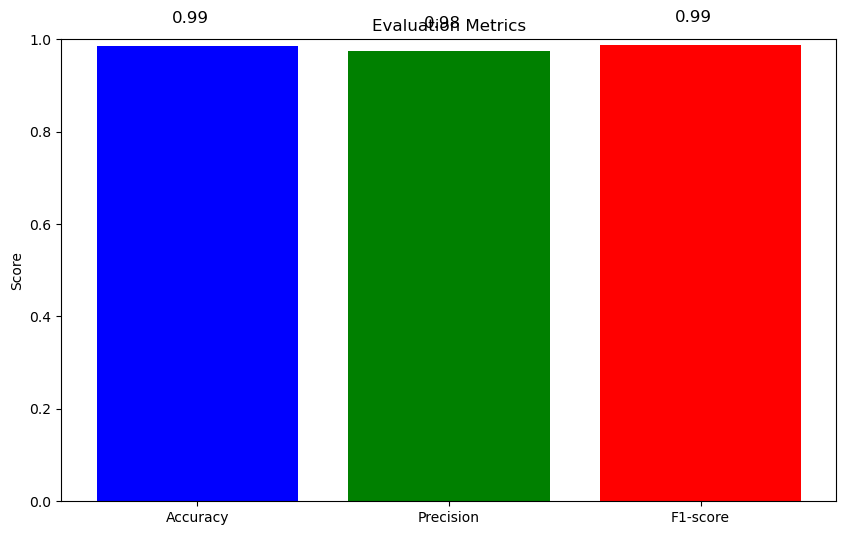

In [28]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_ensemble)
precision = precision_score(y_test, y_pred_ensemble)
f1 = f1_score(y_test, y_pred_ensemble)

# Create grouped bar chart
metrics = ['Accuracy', 'Precision', 'F1-score']
values = [accuracy, precision, f1]
print('accuracy : ' + str(accuracy))
print('precision : ' + str(precision))
print('f1 : ' + str(f1))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Setting y-axis limit to be between 0 and 1
plt.text(-0.1, accuracy + 0.05, f'{accuracy:.2f}', fontsize=12, color='black')
plt.text(0.9, precision + 0.05, f'{precision:.2f}', fontsize=12, color='black')
plt.text(1.9, f1 + 0.05, f'{f1:.2f}', fontsize=12, color='black')
plt.show()